# Introducction

BLABLABLA

# Table of Content

 - 0. Importing librairies
 
 - 1. Preprocessing all the data
    - 1.1. Birth data
    - 1.2. Google Trend Data
        - 1.2.1. Find all Google Trend Data categories
        - 1.2.2. Extracting all Google Trend Data for each categories
    - 1.3. Preprocessing data
        
- 2. Category Selection
    
    - 2.1. By correlation overall
        - 2.1.1. Algorithm
        - 2.1.2. Parameter validation
        - 2.1.3. Run
    - 2.2. By correlation with rolling window
        - 2.2.1. Algorithm
        - 2.2.2. Parameter validation
        - 2.2.3. Run
    - 2.3. By improvement overall
        - 2.3.0. Rolling window validation
        - 2.3.1. Algorithm
        - 2.3.2. Parameter validation
        - 2.3.3. Run
    - 2.4. By improvement with rolling window
        - 2.4.1. Algorithm
        - 2.4.2. Parameter validation
        - 2.4.3. Run
        - 2.4.4. Category analysis
    
- 3. Final Prediction and category visualization
    - 3.1. Final prediction
    - 3.2. Best categories visualization

# 0. Importing librairies

In [1]:
# Importing librairies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.regression.rolling import RollingOLS


# External librairies
# Google trend unofficial API
from pytrends.request import TrendReq

# Image library and word cloud
from PIL import Image
from wordcloud import (WordCloud, get_single_color_func)

# 1. Preprocessing all the data
## 1.1 Birth data

valeurs_mensuelles.csv: containing the number of birth in France for each month from 01-01-2004 to 01-10-2020.<br>

Columns:<br>
- Période: month<br>
- Démographie - Nombre de naissances vivantes - France métropolitaine: number of birth for the corresponding month <br>
- Codes: Codes for explaining what type of value we have in our case we have "P" for 2020 data standing for "provisional" and "A" everywhere else standing for normale value. (see caract.csv for further details)

In [2]:
# Folder with all the csv to export/import
data_folder = './Data/'

# Importing birth data with selecting correct columns and changing columns names
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,birth
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


## 1.2 Google Trend Data

We will use the pytrend library. It's not an official Google trend API but there is no official API provided by google.<br>

First we will need to extract all the different categories.
Next, we will need to extract the queries for each categories in France.

### 1.2.1 Find all Google Trend Data categories

To find all the categories and sub categories we used the pytrends librairie. Google is returning us a nested dictionary with all the categories, their id number and their children categories. A representation of these categories can be found here : https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories <br>

After processing this nested dictionary we obtain a DataFrame `categories_df` containing the following information:
 - id: id of the diffrent category
 - name: Name of this category
 - level: level of this category/ sub category ( 1 is overall parent, 2 is first level, 3 is sub categories, ...)
 - parent: Name of the parent category corresponding to the level we want (if Minlevel = 2, then the name of the parent will be a level 2 category).
 
All these data will be export in one csv file : `categories.csv`.

In [3]:
# Function definition we will use later for extracting data contained in a nested dictionaries with lists.
def extract(dict_in, list_out, list_out2,list_out3 ,list_out4 , parent,i,MinLevel):
    '''
    Recursive function extracting data contained in a nested dictionaries with lists.
    It extract:
     - all integers
     - entry with key 'name'
     - the level (parent/children) of the nested dictionary
     - the parent name of the previous dictionary
     
    The code was adapted from here : https://stackoverflow.com/questions/10569636/how-to-get-all-keysvalues-in-nested-dict-of-list-of-dicts-and-dicts/10569687
    
    INPUT:
        - dict_in: dictionary you want to extract from
        - list_out(1-4): list containing all information found by previous recursion (more details in OUTPUT)
        - parent:  name of last entry with key 'name' and level equal to Minlevel found by previous recursion
        - i: level of previous recursive function
        - Min level: Level at where we want to keep track of parent dictionary
        
    OUTPUT:
        - list_out: list containing all integers entry in dict_in
        - list_out2: list containing all entry entry with key 'name' in dict_in
        - list_out3: list containing all levels of dict_in
        - list_out4: list containing all parent name of dict_in
        - parent: name of last entry with key 'name' and level equal to Minlevel
        - i: level of current recursive function
    '''
    i=i+1                                             # Add one level to recursive function

                                                      # Reverse the dictionary order
    rdict_in = dict()                                 # Prepare a new  dictionary
    for k in reversed(dict_in):                       # For each entry in reversed ordered dictionary
        rdict_in[k] = dict_in[k]                          # Save it in new dictionary
    
    for key, value in rdict_in.items():               # for all entry in reversed dict_in
        if isinstance(value, dict):                       # If value itself is dictionary
            extract(value,
                    list_out, list_out2,
                    list_out3, list_out4,
                    parent, i,MinLevel)                       # Then do recursion and input this dictionary in dict_in
        elif isinstance(value, list):                     # Else if this value is a list
            for key2 in value:                                 # Then for each entry in this list
                extract(key2,
                        list_out, list_out2,
                        list_out3,list_out4,
                        parent,i,MinLevel)                         # Do recursion and input this entry in dict_in
        elif isinstance(value, int):                      # Else if this value is an integer
            list_out.append(value)                             # Add the value to list_out
        elif key=='name':                                 # Else if this value has key == 'name'
            list_out2.append(value)                            # Add this value to list_out2
            list_out3.append(i)                                # Add the level of this value in list_out3
            if i==MinLevel:                                    # If current level is equal to the level we want to keep track of
                parent = value                                     # Then add current value to the parent variable
                list_out4.append('nul')                            # Add the value 'nul' as parent of current value
            else:                                              # Else
                list_out4.append(parent)                           # Add the last parent as parent of current value
    return list_out,list_out2,list_out3,list_out4 , parent ,i # Return the two list to have valid recursion


In [4]:
# Create a trend rquest object with language, timzone offset, number of retry if request fail, time factor to make each retry (wait 0.1s , 0.2s, 0.3s, ...)
pytrends = TrendReq(hl='US-US',tz=60, retries=10,backoff_factor=0.1,)

# Extract all google trend categories in a nested dictionary
categories_dictionary = pytrends.categories()

# Initailaze list for extracting data
categories_ids =[]
categories_names = []
level=[]
parent =[]
# Initialise level, and name for categories with no parents
i=0
init='nul'
# Selecting the level of categroies we want to keep as parent
MinLevel = 2
# Extracting the Categories in the nested dictionary using recursive function
[categories_ids,categories_names,level,parent,init,i] = extract(categories_dictionary,categories_ids,categories_names,level,parent , init,i,MinLevel)

# making a dataframe and drooping duplicates categories (ex: category Programmation id: 31 is a sub category of 'Computer Hardware' and 'Computer science')
categories_df = pd.DataFrame(zip(categories_ids,categories_names,level,parent),columns=['id','name','level','parent']).sort_values(['id','level'])
categories_df=categories_df.drop_duplicates(subset ="id")

# saving to a csv a getting an overview
categories_df.to_csv(data_folder + 'categories.csv')
categories_df

,id,name,level,parent
0,0,All categories,1,nul
1,3,Arts & Entertainment,2,nul
449,5,Computers & Electronics,2,nul
584,7,Finance,2,nul
631,8,Games,2,nul
...,...,...,...,...
511,1393,DVRs & Set-Top Boxes,5,Computers & Electronics
520,1394,Blu-Ray Players & Recorders,6,Computers & Electronics
521,1395,DVD Players & Recorders,6,Computers & Electronics
484,1396,Headphones,5,Computers & Electronics


### 1.2.2 Extracting all Google Trend Data for each categories

To extract the google trend data we will use again the pytrend library.
We will extract the category data by puttint a `interest_over_time` request with certain parameters in our payload:
 - `kw_list`: the keyword list of searches, we input an empty string as we want the full category query number:  `[""]`
 - `geo`: geographical region, we input france as the birth data is in france
 - `cat`: id of the category we want, we input all the categories found before one after the other
 - `timeframe`: timeframe of request, we input the full time from 2004 to 2020.
 
As some category don't have enough data, google trend return an empty list, so we don't save this data and later we will delete the coresponding categories in `categories_df`.

As the API is not official some bugs are common for no reason. 

In [ ]:
# Initializing a dataframe for Google Trend Data
GTD_df = pd.DataFrame()
# for each categories
for j,i in enumerate(categories_df['id']):
    # build request payload empty key word with france geolocation with the i'th category from 2004-01-01 to 2020-12-31
    kw_list = [""]
    pytrends.build_payload(kw_list, geo='FR', cat=i , timeframe='2004-01-01 2020-12-31')
    
    # getting google trend data
    temp = pytrends.interest_over_time()
    
    # if the return is not empty save data (may happen for small categories with not enough data the return is empty
    # Ex : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR)
    if not temp.empty:
        GTD_df[i]=temp.iloc[:,0]   
    
# getting an overview    
GTD_df

An error is araising because pytrend is not unofficial pseudo API for google trend. Therefore some error are raising and they are not solved yet.<br>
As we can read here: https://github.com/GeneralMills/pytrends/issues/413, the error 429 we are obtaining now is often a "Too many request" code but this error is arraising for random number of requests and has no definite solution.<br>
Therefore, we made the preprocessing in another notebook by running it multiple time and made a full dataframe containing all the request that we will import in the next cells.

In [5]:
# Importing google trend data preprocessed exactly the same in another notebook
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)
GTD_df.index = pd.to_datetime(GTD_df.index)
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,100,53,89,54,46,50,74,60,78,43,...,4,67,41,19,29,30,58,84,73,31
2004-02-01,75,53,84,55,46,47,74,55,72,40,...,4,100,52,38,72,60,85,81,92,26
2004-03-01,68,55,85,62,45,50,77,59,77,45,...,2,51,51,21,66,37,39,82,71,26
2004-04-01,56,56,85,59,48,54,78,55,76,43,...,3,88,89,33,76,75,56,78,98,26
2004-05-01,75,56,86,50,47,54,75,59,76,45,...,3,14,51,23,45,59,100,70,78,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,44,33,18,53,24,81,54,25,55,58,...,31,9,12,9,23,34,79,50,20,9
2020-09-01,48,32,20,61,23,74,60,28,58,53,...,31,14,24,9,32,24,76,42,11,9
2020-10-01,52,33,21,62,25,80,63,28,61,55,...,34,11,19,11,33,18,78,43,9,10


## 1.3. Preprocessing data

In [6]:
#Function to standardize data
def standardize(data):
    '''
    Standardize the data by removing the mean and dividing by standard deviation
    
    Input:
        -data: data to standardize
    
    Output:
        -x: standardized data
    '''
    mean_x = np.mean(data)
    std_x = np.std(data)
    x = data
    x = x - mean_x
    for i in range (len(std_x)):
        if std_x[i] == 0:
            std_x[i]=1
    x = x / std_x
    return x

In [7]:
# Make columns name to numeric
col = pd.to_numeric(GTD_df.columns)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]

# standardize the Google Trend Data
GTD_df = standardize(GTD_df)

# Remove seasonnality 
# Make function

# Shifting columns to make Auto Regressive model
nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space

In [7]:
### Function useful for below

#Function to show the plot with same format from paper
def showPlot(df, improvement_overall):
    '''
    df: DataFrame with all the parameters to plot (birth; predict_base; predict_trend)
    improvement_overall: value of the improvement
    '''
    
    #Defining the overall parameters for the figure
    params = {'legend.fontsize': 20,
              'legend.handlelength': 3,
              'figure.figsize': (15,10),
              'axes.labelsize' : 15,
              'xtick.labelsize' : 15,
              'ytick.labelsize' : 15}
    plt.rcParams.update(params) #applying them

    #plotting each curve with specific parameters
    fig, ax = plt.subplots()
    ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
    ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
    ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

    #Defining figure title
    plt.suptitle('Births in France', fontsize=20)

    #Defining (x;y) labels
    plt.xlabel('Index')
    plt.ylabel('log(mvp)')

    #Plotting the legend
    plt.legend(loc="upper right")

    #Creating the box with the MAE improvements
    textstr = '\n'.join((
        r'MAE improvement',
        r'Overall = $%.1f$%%' % (improvement_overall, )))
    ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

    #Showing the plot
    plt.show
    return



## 2.0 Methodology

### 2.0.1 Basic Model

The model used to predict the next month value based on the basic data is: <br>
\begin{equation}
y_t = a_0 + a_1 y_{t-6} + a_2 y_{t-12}
\end{equation}<br>
Where:<br>
- $y_t$: is the predicted value at time t
- $y_{t-6}$ is the value from the date 6 months before
- $y_{t-12}$ is the value for the same month but the previous year
- $a_0, a_1, a_2$ are coefficient calculated by the ordinary least square regression <br> <br>

We add all the parameters from the rolling ols to the reference dataframe but shifted one row down in order to use them to predict the next month.<br>
Afterward we compute linearly in our reference dataframe to predict the value for each month.

### 2.0.2 Trend Model

The model used to predict the next month value based on the basic data + google trend data is: <br>
\begin{equation}
y_t = a_0 + a_1 y_{t-6} + a_2 y_{t-12} + a_3 gtd_{category,t}
\end{equation}<br>
Where:<br>
- $y_t$: is the predicted value at time t
- $y_{t-6}$ is the value from the date 6 months before
- $y_{t-12}$ is the value for the same month but the previous year
- $gtd_{category}$  is the number of queries of the selected google category at the given date
- $a_0, a_1, a_2$ are coefficient calculated by the ordinary least square regression <br> <br>

We add all the parameters from the rolling ols to the reference dataframe but shifted one row down in order to use them to predict the next month.<br>
Afterward we compute linearly in our reference dataframe to predict the value for each month.

## 2.1. By correlation overall
The idea of this part is to determine which category of google trends has the best correlation with the number of births in France over the entire data set (from 2004 up to 2020). In order to do this we are going to use 3 correlations factors:
- Kendall correlation
- Pearson correlation
- Spearman correlation


**Kendall correlation:**

\begin{equation}
    \tau = \frac{(Number\:of\:concordants\:pairs) - (Number\:Of\:discordant\:pairs)}{\frac{n(n-1)}{2}}
\end{equation}
With:
- $\tau$: The Kendall coefficient
- $n$: The number of samples


**Pearson correlation:**
\begin{equation}
    \rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X\sigma_Y}
\end{equation}
With:
- $X$ & $Y$: The google Trend data and the birth data at a given date / rank
- $\rho_{X,Y}$: Peason correlation between X and Y 
- $cov(X,Y)$: The covariance of X and Y
- $\sigma_X$: The standard deviation of X
- $\sigma_Y$: The standard deviation of Y


**Spearman correlation:**
\begin{equation}
    \rho = 1 - \frac{\sum d_i^2}{n(n^2-1)}
\end{equation}
With:
- $\rho$: Spearman correlation
- $d_i$: Difference between the ranks of the corresponding variables
- $n$: The number of observations

---

We then take the absolute values of each correlation and normalize them over 100 in order for them to be on the same scale.

\begin{equation}
    Corr_{xxx} = \frac{|Corr_{xxx}|}{Corr_{xxx,max}}*100
\end{equation}

This allows us to calculate the mean value of the 3 correlations and we take the one with the overall best correlation.

\begin{equation}
    Corr_{mean} = \frac{Corr_{spearman} + Corr_{pearson} + Corr_{kendall}}{3}
\end{equation}


### 2.1.1. Algorithm

In [8]:
# Importing birth data with selecting correct columns and changing columns names
#######################
#### TO DELETE ########
#######################
#####OLD WORKSPACE#####
#######################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from numpy import linalg as LA

data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','birth'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['birth'] = birth_df['birth'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()

GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)
GTD_df.head(10)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df = standardize(GTD_df)

# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]


nan = np.empty(6)
nan[:] = 0
birth_df['birth_6'] =  [*nan , *birth_df.birth[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
birth_df['birth_12'] =  [*nan , *birth_df.birth[:-12].values] # Moving down 12 rows and putting 0 in the empty space 

In [9]:
#function definition

#10 best features selection based on its correlation with the birth number
def bestFeatureCorrelation(date, k):
    '''
    Input:
        date: date at which we want to determine the correlation
        k: size of the data we want to check the correlation on (size recommended: identical to the ORLS)
    Output:
        categories_best: 10 best categories
    '''    
    
    #Number of month in which we should look for correlation before choosing the best (size of the rolling ols)
    pearson = [] #df in which we store the pearson correlation factor
    kendall = [] #df in which we store the kendall correlation factor
    spearman = [] #df in which we store the spearman correlation factor
    
    end_date = datetime.strptime(date, '%Y-%m-%d')  
    start_date = end_date - relativedelta(months=+k)

    end_date = datetime.strftime(end_date, '%Y-%m-%d')
    start_date = datetime.strftime(start_date, '%Y-%m-%d')

    temp_df=pd.DataFrame(GTD_df.loc[start_date:end_date], dtype='float') #Taking the time index that are also in the birth_df
    birth_temp = pd.DataFrame(birth_df.loc[start_date:end_date], dtype='float')
    for i,j in enumerate(categories_df['id']):

        if str(j) in temp_df.columns:
            #Pearson correlation calculation
            pearsonTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
            pearson.append(pearsonTemp)
            #Kendall correlation calculation
            kendallTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
            kendall.append(kendallTemp)
            #Spearman correlation calculation
            spearmanTemp = np.abs(birth_temp.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
            spearman.append(spearmanTemp)

        else:
            #if the correlation could not be calculated -> put NaN
            pearson.append(np.nan)
            kendall.append(np.nan)
            spearman.append(np.nan)

    #Normalizing our correlation indicators in order to combine them and compare them
    pearsonNorm = 100 / np.nanmax(pearson)
    categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
    kendallNorm = 100 / np.nanmax(kendall)    
    categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
    spearmanNorm = 100 / np.nanmax(spearman)
    categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

    #Crossing between our correlations to see which feature is the best
    cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
    cal = cal.mean(axis=1)
    categories_df['Mean'] = cal

    #Taking the 10 best
    categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:100,:].reset_index(drop=True)
    return  categories_best

def predictionCorr(date,k,birth_df,GTD,ids):
    '''
    Input:    
        date: dates at which we want to predict
        k: size of the rolling windows
        df: birth df
        temp_GTD: Google Trends DF
        ids.: ids of category
    Output:
        df: the dataframe we've worked with
        improvement_overall: the improvement
        mae_trends: the mae of the standard + trends model
    '''
    
    #Setting up temporary dataframes
    df = birth_df.copy()
    temp_GTD = GTD_df.copy()
    
    #Taking the right times for the dfs
    end = datetime.strptime(date, '%Y-%m-%d')  
    start = end - relativedelta(months=+k)
    end = datetime.strftime(end, '%Y-%m-%d')
    start = datetime.strftime(start, '%Y-%m-%d')
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[start:end]
    
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format
    
    #Doing the OLS with the standard data
    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    #Doing OLS with the standard + google trends data
    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall, mae_trends

#Function to return all the value in the date range
def dateRange(start_date, end_date,k):
    '''
    Input:
        start_date: start date of the date range
        end_date: end date of the date range
    Output:
        list of date between start+k and end
    '''   
    
    rep = len(pd.date_range(start_date,end_date, freq='M'))#Iteration number to do
    for n in range(k, rep): #from k to end date
        yield start_date + relativedelta(months=n) #return the list


### 2.1.2. Parameter validation

Here we will find the features with the best correlation over all the dataset based on the method detailed in 2.1

In [58]:
date = '2020-11-01' #The date before which we want to calculate the correlations
k = GTD_df.shape[0] #The size of the data we want to check the correlation on (the entire dataset here)

corr = bestFeatureCorrelation(date, k) #Calculating the correlations
best=corr.id[0:20] 
corr #Showing the 100 best features best on their correlation 

,id,name,Pearson,Kendall,Spearman,Mean
0,1211,ORL,100.000000,94.823018,93.763942,96.195653
1,1253,Actualités de la santé,83.949198,100.000000,100.000000,94.649733
2,1238,Nettoyage du corps et désintoxication,98.979640,90.929204,91.393587,93.767477
3,1256,Politique sanitaire,81.018001,96.940508,97.343253,91.767254
4,645,Pédiatrie,94.640563,89.961860,89.851515,91.484646
...,...,...,...,...,...,...
95,504,Services et ressources de création de blogs,55.003758,77.190114,80.706986,70.966953
96,55,Rencontres,63.030100,72.774187,77.005931,70.936739
97,8,Jeux,68.394429,69.304808,74.852340,70.850526
98,143,Soins du visage et du corps,68.887820,70.091036,73.430193,70.803016


Here we will find the best rolling window size that minimizes the MAE for the google trend model

We will search in the range from 4 months (minimum size as we have 3 features) to 3 years so 36 months

In [59]:
#Finding the best rolling windows to minimize MAE Trend with 1 category of google trend (here ORL)

output = pd.DataFrame(index=np.linspace(0,36,37), columns=["k", "MAE Trend", "Improvement"]) #our output df

#We look for the best rolling windows size in 
for k in range (4,37): #starting at 4 as k>=feature_number until 36 (3x12 3 years rolling window)
   
    #Date processing
    start_date = '2005-01-01' 
    end_date = '2020-10-01'
    start_date = datetime.strptime(start_date, '%Y-%m-%d')  
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    #arrays to store the data
    imp = []
    trend = []
    birth = []
    maeTrend = []
    
    #Predicting the values for each date
    for single_date in dateRange(start_date, end_date, k):#Going over the range of date
        date = single_date.strftime("%Y-%m-%d")
        df2, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[0:1].values) #Predicting    
        birth.append(df2['birth'][-1]) #Real data
        trend.append(df2['predict_trend'][-1]) #Trend prediction 
        imp.append(impt) #improvement for the date
        maeTrend.append(mae_trendt) #improvement for the date

    output.iloc[k] = [k, np.mean(maeTrend), np.mean(imp)] #Storing the data
    print("Run: %.5f || MAE Trend: %.5f || Improvement: %.5f" % (k, np.mean(maeTrend) , np.mean(imp)) ) #Showing off

C:\Users\pierr\anaconda3\lib\site-packages\statsmodels\regression\rolling.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)


Run: 4.00000 || MAE Trend: 26.75761 || Improvement: -2116.29893
Run: 5.00000 || MAE Trend: 3.73223 || Improvement: -218.00614
Run: 6.00000 || MAE Trend: 2.63457 || Improvement: -119.78099
Run: 7.00000 || MAE Trend: 2.06468 || Improvement: -94.93461
Run: 8.00000 || MAE Trend: 2.03483 || Improvement: -68.81855
Run: 9.00000 || MAE Trend: 2.05691 || Improvement: -95.64308
Run: 10.00000 || MAE Trend: 2.08750 || Improvement: -102.82392
Run: 11.00000 || MAE Trend: 2.07531 || Improvement: -101.76297
Run: 12.00000 || MAE Trend: 2.05322 || Improvement: -109.83972
Run: 13.00000 || MAE Trend: 2.06492 || Improvement: -70.72308
Run: 14.00000 || MAE Trend: 2.00462 || Improvement: -28.74018
Run: 15.00000 || MAE Trend: 2.00382 || Improvement: -128.59134
Run: 16.00000 || MAE Trend: 1.99324 || Improvement: -40.87582
Run: 17.00000 || MAE Trend: 1.95455 || Improvement: -19.13393
Run: 18.00000 || MAE Trend: 1.93834 || Improvement: -16.41086
Run: 19.00000 || MAE Trend: 1.83159 || Improvement: -40.78071
Run: 

<function matplotlib.pyplot.show(close=None, block=None)>

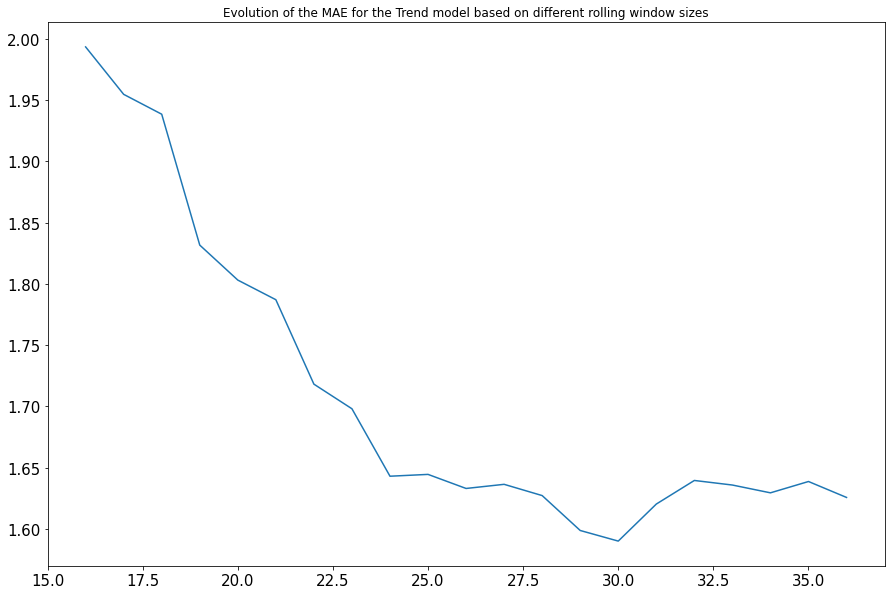

In [62]:
output.dropna()
output = output[output["MAE Trend"]<2] #Discarding outsiders that won't fit in the plot

plt.title("Evolution of the MAE for the Trend model based on different rolling window sizes")
ax = plt.plot(output["MAE Trend"])
plt.show

In [63]:
#Finding the window size that gives us the lowest MAE for the Trend model
k_best = output[output["MAE Trend"] == np.min(output["MAE Trend"])] 
k_best #show off

,k,MAE Trend,Improvement
30.0,30,1.59018,-124.73


### 2.1.3. Run

Now that we have the category with the best correlation for the births in France and the best rolling windows size to minimize the MAE with the google trends model we will run our model over the entire dataset

In [64]:
#Testing our optimised df for the best MAE trend

k = int(k_best.k) #Previously calculated rolling window size

#Date Processing
start_date = '2005-01-01' 
end_date = '2020-10-01'
start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')

#Place to store the output
imp = []
base = []
trend = []
birth = []
maeTrend = []

#Calculating the prediction
for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    dft, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[0:1].values) #Predicting    
    birth.append(dft['birth'][-1]) #Real data
    base.append(dft['predict_base'][-1]) #Base prediction
    trend.append(dft['predict_trend'][-1]) #Trend prediction 
    imp.append(impt) #improvement for the date

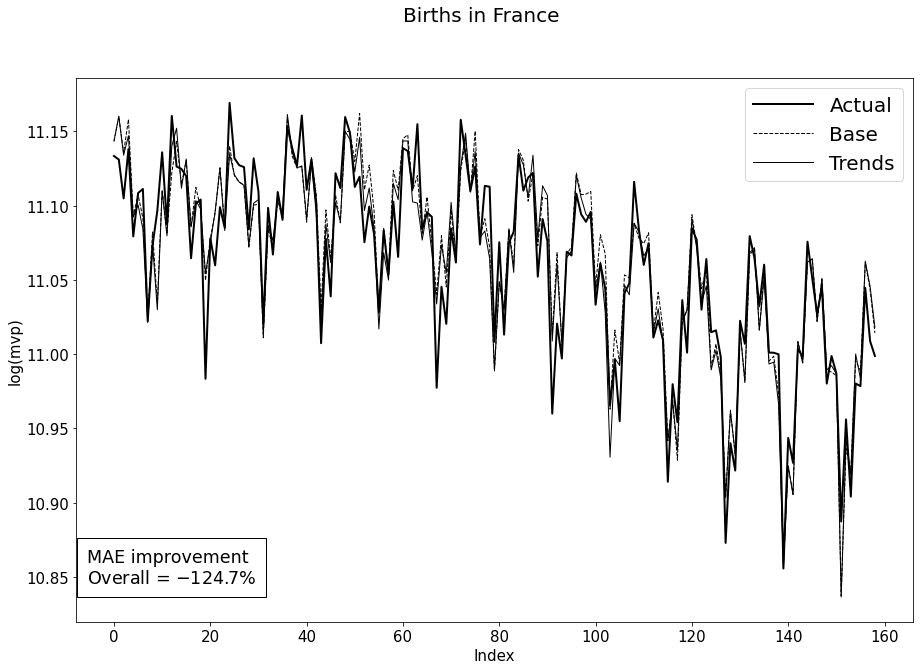

In [65]:
#Setting up the df to plot
df = pd.DataFrame()
df["birth"]=birth
df["predict_base"]=base
df["predict_trend"]=trend
improvement_overall = np.mean(imp)

showPlot(df, improvement_overall) #Plotting

## 2.2. By correlation with rolling window

### 2.2.1 Algorithm

In [27]:
#Count frequency
def CountFrequency(my_list): 
    '''
    Couting frequency of occurences in my list and out put it in a dictionary
  
    Input:
      - my_list: list we want to count occurances from

    Output:
      - freq : dictionary in the form {key1: # of occurences, key2: # of occurences, ...}
    '''
    # Creating an empty dictionary  
    freq = {} 
    # For each items
    for item in my_list: 
        # If already in dictionary add one to frequency
        if (item in freq): 
            freq[item] += 1
        # Else create entry with freq = 1
        else: 
            freq[item] = 1
    
    return freq

def CountFreqColor(colorpallete, parent,freqparents,words):
    '''
    Counting frequency of occurences in my list and out put it in a dictionary.
    Additionally add them in a color dictionary according to the occurencies of the parent list.
    
    Input:
        - colorpallete: the color palette we want as strings (therefore can be in RGB, hex, ...)
        - parent: The strings containing the parent 
        - freqparents: A dictionary containg the occurancies of the parents (can be easily made from a list with fucntion CountFrequency)
        - words: List of word we want to split by color and parent occurancies
    Output:
        - freq: dictionary of the word occurancies in the form {key1: # of occurences, key2: # of occurences, ...}
        - color: dictionary with the color and all the word sorted by their parent frequency in the form 
                 { color1 : List(all the word with the 1st most occuring parent), color2: List(all the word with the 2nd most occuring parent),
                   ..., lastcolor: List(all the other word) }
    '''
    
    # Creating empty dictionaries
    freq = {} 
    color = {}
    # For each word items
    for j,item in enumerate(words): 
        # If already in dictionary add one to frequency
        if (item in freq): 
            freq[item] += 1
        # Else
        else: 
            # Create entry with frequency 1
            freq[item] = 1
            # Search coresponding parent
            search_key = parent[j]
            # Find the occurencies of the parent
            list_temp = list(freqparents.items())
            # And find the rank of the parent by occurancies
            temp =[idx for idx, key in enumerate(list_temp) if key[0] == search_key][0]
            # If this rank is bigger than the length of color palette
            if temp >=len(colorpallete)-1:
                # take last color
                temp = len(colorpallete)-1
            # Take correct color
            color_temp = colorpallete[temp]
            # If color already in dictionary add word to the list
            if color_temp in color:
                color[color_temp].append(item)
            # Otherwise create a new entry with the word
            else:
                color[color_temp] = [item] 
    return freq,color

# Function given by wordcloud examples on the library website: https://amueller.github.io/word_cloud/


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

### 2.2.2. Parameter validation

In this part we will try to optimise 2 parameters:
- The rolling window size
- The google trends category

In order to do so we will:
- Take a given rolling window k within the range [4-40] 
- Find the category that has the best correlation in the past k month from the date we are trying to predict
- Run a prediction for each k with specific categories for each date
- Take the k that gives the lowest mean value of MAE Trends


In [ ]:
##########################
## DON'T RUN # TOO LONG ##
##########################

output = pd.DataFrame(index=np.linspace(0,210,211), columns=["k","MAE Base", "MAE Trend", "Improvement"])
for k in range (4,37):
    #Data for correlation
    start_date = '2005-01-01' 
    end_date = '2020-10-01'

    #for k in range (4,40)
    #Date processing
    start_date = datetime.strptime(start_date, '%Y-%m-%d')  
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    #output dataframe for the best parameters
    best = pd.DataFrame()

    #Loop in which we find the best hyper parameters with correlation
    for single_date in dateRange(start_date, end_date, k):
        date = single_date.strftime("%Y-%m-%d")
        corr = bestFeatureCorrelation(date, k)
        best[date]=corr.id[0:10]


    imp = []
    base = []
    trend = []
    birth = []
    maeBase = []
    maeTrend = []
    #Predicting the values for each date

    for single_date in dateRange(start_date, end_date, k):
        date = single_date.strftime("%Y-%m-%d")
        aze, impt, mae_baset, mae_trendt = prediction(date,k,birth_df,GTD_df,best[date][0:1]) #Predicting    
        birth.append(aze['birth'][-1]) #Real data
        base.append(aze['predict_base'][-1]) #Base prediction
        trend.append(aze['predict_trend'][-1]) #Trend prediction 
        imp.append(impt) #improvement for the date
        maeBase.append(mae_baset) #improvement for the date
        maeTrend.append(mae_trendt) #improvement for the date
    
    output.iloc[k] = [k,np.mean(maeBase), np.mean(maeTrend), np.mean(imp)]
    print("Run:", k, "|| MAE Base:", np.mean(maeBase), "|| MAE Trend:", np.mean(maeTrend), "|| Improvement:",np.mean(imp))

In [ ]:
output = output.dropna()
MaeTrend = output["MAE Trend"]

In [12]:
#The previous cell was ran and the results harcoded in order to same some time
#One who has spare time can run it and will have the same results
MaeTrend = pd.DataFrame([np.nan, np.nan, np.nan, np.nan, 8.081609884810343, 2.837861126900694, 2.065574462392271, 
            1.7862611522337535, 1.7042057333869982, 1.84528428532989, 1.677494726762073, 1.7940966652070183, 
            1.7405841229851622, 1.6636901406360616, 1.6991142141610194, 1.7541018276558975, 1.877600994069425, 
            2.004126810502877, 1.8337459019953573, 1.7448858701141965, 1.8271773927381978, 1.7955265215814364,
            1.7260588510921366, 1.6743005713791963, 1.7249091776468428, 1.7060644918306502, 1.7411751146003709,
            1.7284818688144787, 1.6727550656583408, 1.6535121808530175, 1.6271999944477737, 1.6348469310998994, 
            1.6486298696652602, 1.6585134552948295, 1.6474716660718776, 1.6366504599673888, 1.6188135144448226, 
            1.668446798120343, 1.6605479652305233, 1.6345435888604376])

In [13]:
k_best = (MaeTrend[MaeTrend == np.min(MaeTrend)].dropna())
k_best

,0
36,1.618814


---
Now we have the best rolling window size (i.e k=36), we will re-calculate the best categories

In [14]:
#Data for correlation
start_date = '2005-01-01' 
end_date = '2020-12-01'
k = k_best.index[0]


#Date processing
start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')


best = pd.DataFrame()

for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    corr = bestFeatureCorrelation(date, k)
    best[date]=corr.id[0:20]
    if single_date.month == 1:
        print(date)

2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01
2019-01-01
2020-01-01


In [15]:
#This show the 5 most correlated category during the 36 last months of each month
best.head(5)

,2008-01-01,2008-02-01,2008-03-01,2008-04-01,2008-05-01,2008-06-01,2008-07-01,2008-08-01,2008-09-01,2008-10-01,...,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01
0,734,1135,1135,1135,1135,1135,1135,1135,1135,1135,...,1210,1210,1210,819,819,819,819,819,819,819
1,1135,1116,244,244,1116,963,1116,1116,1116,1096,...,665,665,665,665,1210,665,1210,1210,457,457
2,1083,1094,1116,1220,963,1116,963,963,963,963,...,1260,1260,819,1210,665,1210,665,457,1210,1210
3,366,244,1220,1116,244,1220,1096,1096,1096,1116,...,1305,689,1305,1211,630,630,457,665,665,665
4,825,366,1094,1094,1220,244,1094,1094,1094,244,...,1148,1305,689,645,645,1305,1305,1305,630,386


## 2.2.3 Category visualisation

Now we will show in a nice and visual manner the number of occurences of the category used in the trend model in order to have an idea of what category are selected and what theme they are in 

In [22]:
categories_df = categories_df.set_index(categories_df.id, drop = True)

In [23]:
#For each month we associate the category id with its actual name
categories_best = pd.DataFrame(categories_df.loc[best.loc[0,:].values, "name"])
categories_best = categories_best.reset_index()

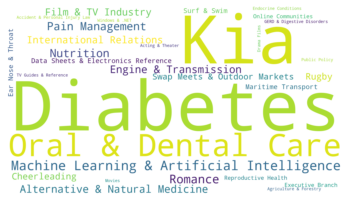

In [25]:
#Occurence with best correlated category
s = CountFrequency(categories_best['name'])

text = ("+").join(categories_best['name'])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1920, height=1080,background_color="white").generate_from_frequencies(s)   #regexp=r"\w[\w' ]+"

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#text

In [28]:
# Nice colors from coolors.co
b=["#da0019","#339900","#005799","#bb00be","#011627"]

Parents = [str(categories_df[categories_df['id']==i]['parent'].values)[2:-2] for i in categories_best['id']]
words = [str(categories_df[categories_df['id']==i]['name'].values)[2:-2] for i in categories_best['id']]


s = CountFrequency(Parents)
s = {k: v for k, v in sorted(s.items(), key=lambda item: item[1],reverse=True)}

[words,color] = CountFreqColor(b, Parents,s,words)


wc = WordCloud(relative_scaling=0.8 ,background_color="white",width=500, height=500).generate_from_frequencies(words)   #regexp=r"\w[\w' ]+"

default_color = 'grey'
# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)


labels=list(s.keys())
legend_elements = []
for i in range(4):
    legend_elements.append(Patch(facecolor=b[i],label=labels[i]))

legend_elements.append(Patch(facecolor=b[4],label='Other'))

fig, (ax1, ax2) = plt.subplots(1,2)
ax2.legend(handles=legend_elements, loc='center left', prop={'size': 10})
ax2.axis('off')

# Display the generated image:
img_size = 30
plt.figure(figsize=(10, 10))#(img_size,img_size*16/9))
ax1.imshow(wc, interpolation='bilinear')
ax1.axis("off")
plt.show()

NameError: name 'get_single_color_func' is not defined

### 2.2.4. Run

Now that we have the best rolling window size (ie: k=36) and the best categories we can start to predict

In [134]:
start_date = '2005-01-01' 
end_date = '2020-10-01'
k = k_best.index[0]

start_date = datetime.strptime(start_date, '%Y-%m-%d')  
end_date = datetime.strptime(end_date, '%Y-%m-%d')

imp = []
base = []
trend = []
birth = []
maeTrend = []
    
for single_date in dateRange(start_date, end_date, k):
    date = single_date.strftime("%Y-%m-%d")
    dft, impt, mae_trendt = predictionCorr(date,k,birth_df,GTD_df,best[date][0:1]) #Predicting    
    birth.append(dft['birth'][-1]) #Real data
    base.append(dft['predict_base'][-1]) #Base prediction
    trend.append(dft['predict_trend'][-1]) #Trend prediction 
    imp.append(impt) #improvement for the date

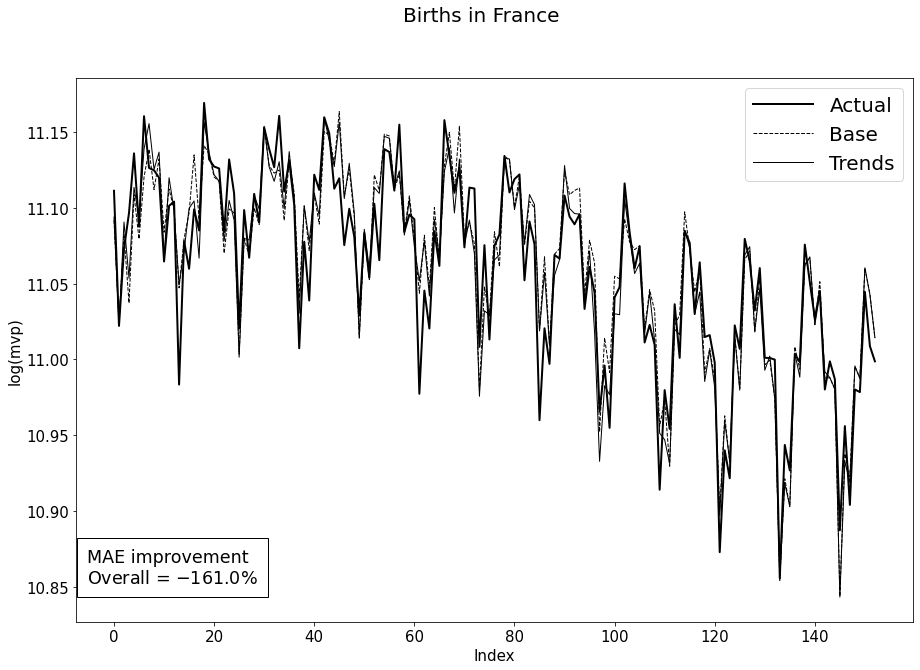

In [135]:
df = pd.DataFrame()
df["birth"]=birth
df["predict_base"]=base
df["predict_trend"]=trend
improvement_overall = np.mean(imp)

showPlot(df, improvement_overall)

## 2.3. By improvement overall

Next we will try to select the categories by finding the category that give us the best prediction overall.<br>
To do that, we will predict our data using our Auto Regression model with each one of our categories. Find the final improvement (because we don't change the base model we can just take a look to MAE of our trend model) and then select the categories based on the best improvement.<br>
This implies imputing every Google Trend Data we have in the formula (2), predict births data for the whole period and compute the MAE. Then we can sort the categories by their MAE, and select the few best ones to predict (again) the birth data.

This is not a "in-sample fit" because even if we search the best category by comparing with the known number of births, after knowing the best categories we predict each data point knowing only the past ones and the current data of the most useful category using a Auto Regression model. This is just a just of finding the most useful categories and then the categories can be used later for all predicition.

### 2.3.0. Rolling window validation

In the base model we need to validate the rolling-window hyperparameters `k`. Therefore we will find which rolling window give the smallest Mean Absolute Error (MAE). <br>
We don't want to have a really big rolling window because a big rolling window imply a lot of past data required for prediction but with a larger rolling window and therefore, more data, the model give often better results. Therefore we accept k from 10 month to 29 months.

In [23]:
def prediction_bestK(k,data,start ='2004-01-01',end ='2020-11-01'):
    '''
    For a list of rolling window size, find the mae of the base model
    
    Input:
        -start/end: start and end date of data
        -k : list of possible rolling window
        -data: the data we want to predict on
        
    Ouput:
        -MAES: an array containing the MAE of each k
    '''
    
    # Creating list four saving data
    MAES = []
    # For each rolling window
    for i in k:
        # Creating new df and selcting correct date
        df = data.copy()
        df = df.loc[start:end]
        # Saving the index for later plotting
        index_date = df.index
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format
        
        # Prediction with base model
        res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=i).fit() #We use our rolling windows function
        params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month
         
        # add correct date index again
        df.index = index_date
    
        #MAE calculation and saving it to list
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        MAES.append(mae_base)
        
    return MAES


In [33]:
# Creating a list of possible rolling window size
k = list(range(10,29))

# Copying dataframe to not overwrite
df = birth_df.copy()

# Find the best K and output it in nice Dataframe
MAES = prediction_bestK(k,df)
MAES = pd.DataFrame([MAES],columns=[['MAE Base k = %d' % x for x in k] ])

MAES

,MAE Base k = 10,MAE Base k = 11,MAE Base k = 12,MAE Base k = 13,MAE Base k = 14,MAE Base k = 15,MAE Base k = 16,MAE Base k = 17,MAE Base k = 18,MAE Base k = 19,MAE Base k = 20,MAE Base k = 21,MAE Base k = 22,MAE Base k = 23,MAE Base k = 24,MAE Base k = 25,MAE Base k = 26,MAE Base k = 27,MAE Base k = 28
0,1.9638,2.000192,2.046532,2.078426,2.028978,2.014081,2.03942,2.01746,2.031788,1.976743,1.928902,1.939169,1.883182,1.88641,1.85148,1.887508,1.895344,1.897849,1.894857


In [34]:
# Selecting the best rolling window k
t = MAES.values.argmin()
k = k[t]
k

24

As we an read from the previous cell, the best rolling window is `k=24`.

### 2.3.1. Algorithm

In [35]:
#function definition
def best_feature_improvement(k,start = '2004-01-01', end = '2020-10-01'):
    '''
    Rank the categories corresponding to there MAE on the period selected.
    
    Input: 
        - k: rolling windiw size
        - start: start date in format '2004-01-01'
        - end: end date in format '2020-10-01'
    
    Output:
        - categories_best: A list of the categories ordered by improvement compared to the base model during the selected period
    '''

    # Keep track of all the mae
    mae = []
    
    # For each categories
    for i in GTD_df.columns:

        # Creating a new Dataframe
        df = birth_df.copy()
        
        # Selecting the correct period
        df = df.loc[start:end]
        temp_GTD_df = GTD_df.loc[start:end]
        # Setting up the category of interest
        df["y0"] = temp_GTD_df[i]
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format

        # Trend model with the selected category
        res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=k).fit()# We use our rolling windows function
        params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) # We shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['b0','b1','b2','b3']# Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) # Adding it to our dataframe
        df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   # Predicting the values for the next month

        #Calculating MAE and Improvement
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        
        # Adding the improvement to our records
        mae.append(mae_trends)


    # Making a df with all the categories ordered correctly
    categories_best = categories_df.reset_index(drop=True)
    categories_best['mae'] = pd.DataFrame(mae)
    categories_best = categories_best.sort_values('mae', ascending=True)
    categories_best = categories_best.reset_index(drop=True)
    
    return categories_best

def make_date_best(best):
    '''
    From a list of best categories, create an dataframe containing the n'th best categories for each date
    
    Input:
        - best: Dataframe the categories ordered
    Output:
        - temp: a dataframe with the categories at each date
    '''
    # Creating a Dataframe with the correct dates
    temp = pd.DataFrame(index = birth_df.index)
    # Reset index to make sure we select the correct one
    best.reset_index(drop=True)
    # For the number of best category we want
    for i in range (number_of_best_cat):
        # Add them at each date
        temp[str("id{}".format(best.index[i]))] = np.ones((len(birth_df),1)) * best.id.iloc[i]
        
    return temp

# Function predicting
def prediction(start,end,k,data,GTD,ids):
    df = data.copy()
    temp_GTD = GTD.copy()
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[str(start-pd.DateOffset(months=1)):str(end)]
        
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(int(i))]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date
    return df

### 2.3.2. Parameter validation

There is no validation for the rolling window k as it was done before.<br>
However we will need to find the best number of category for the prediction.

In [36]:
best_cat =list(range(1,5))

improvement=[]
for number_of_best_cat in best_cat:
    best_id = best_feature_improvement(k)
    best_id = make_date_best(best_id)
    months_shift = k
    
    # Reset dataframes
    temp_df=pd.DataFrame(GTD_df, dtype='float')
    df = birth_df.copy()

    # Predict with these categories
    # Create empty prediction
    predict_base=[np.nan]*(months_shift+1)
    predict_trend=[np.nan]*(months_shift+1)
    # for each date
    for i in range(months_shift+1,len(birth_df)):
        # find current month
        j=birth_df.index[i]
        # find category corresponding to current month
        ids = best_id.loc[j,:]
        # Predict current value with current category
        pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
        # Save prediction
        predict_base.append(pred['predict_base'][-1])
        predict_trend.append(pred['predict_trend'][-1])

    # Save predictions
    df['predict_base'] = predict_base
    df['predict_trend'] = predict_trend

    # Compute maes and improvement
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base

    # Save improvement for current number of categories
    improvement.append(improvement_overall)
    
Improvement = pd.DataFrame([improvement], columns=best_cat)
Improvement

,1,2,3,4
0,3.523319,2.281006,1.259027,0.532247


In [37]:
# Selecting the best number of categories
number_of_best_cat = best_cat[Improvement.values.argmax()]
number_of_best_cat

1

As we can read from the previous cell, the best number of categories is 1.<br>
This can be explain by the fact that the linear regression don't know that this category is less useful and will find coefficients (different from 0) for it as we make a out of sample fit. Therefore the prediction will be worse as we add "bad data in the model".

### 2.3.3. Run

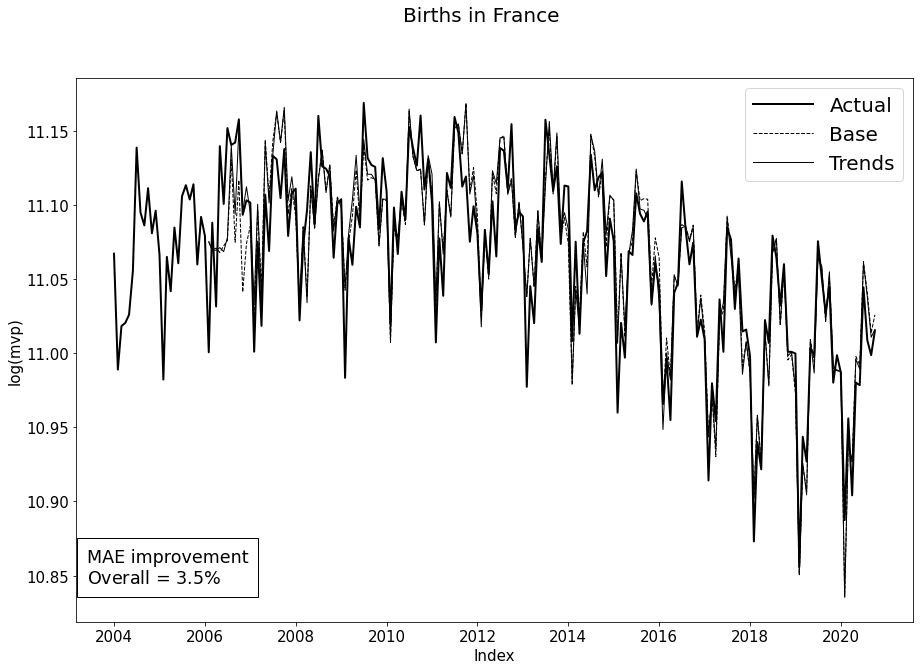

In [38]:
# find best feature overall
best_id = best_feature_improvement(k)

# Transforming the id into a date array for correct prediction
best_id = make_date_best(best_id)

# updating the months shift variable for later use
months_shift = k


# Reset dataframes
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

# Predict with these categories
# Create empty prediction
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
# for each date
for i in range(months_shift+1,len(birth_df)):
    # find current month
    j=birth_df.index[i]
    # find category corresponding to current month
    ids = best_id.loc[j,:]
    # Predict current value with current category
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    # Save prediction
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

# Save predictions
df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

# Compute maes and improvement
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

showPlot(df, improvement_overall)

## 2.4. By improvement with rolling window

Finally, to improve our results of the last section, we will try to find the n'th best categories of the m'th past months and use it to predict the current month. <br>
For example, if you want to find the best possible categories on july 2018:
 - if shift = 1 you will look at the n'th best categories to predict june 2018
 - if shift = 3 you will look at the n'th best categories to predict april,may and june 2018
and then output these categories for the month of july 2018.<br>
In this notebook, we will call the variable n `number_of_best_cat` and the variable m `shift`.<br>

To find the best category on the last m'th month, we need to predict each of the past m'th months with all the categories and then take the n'th best ones. This method can be seen as a brute force approach because to have correct regression coefficients, we need to predict for each month all the categories and not just select the coefficients corresponding to the correct period.

So mathematically, we will do the same as the previous question but in a loop selecting the correct time range. Because we have a window (shift'th month) in a window (rolling window k), we will need to select from month t-k-shift to month -1. And then predict with all categories to finally sort the categories by their mae.

However, this method is again a out-of-sample approach because we try to find the best categories on the last m'th month and then assuming this category is a good one for predicting the present month. We don't really know if the best categories on last months will be the bests for the actual month but it make sense that these categories will be good and will help our prediction.


### 2.4.1. Algorithm

In [39]:
#function definition
def best_feature_improvement_rolling(shift):
    '''
    Find the best categories on the past shift'th months. 
    Exemple: You want to find the best possible categories on july 2018 
                if shift = 1 you will look at the best categories to predict june 2018
                if shift = 3 you will look at the best categories to predict april,may and june 2018
             and output these categories for the month of july 2018.
    Input:
        - shift : the number of months you want to look back
    
    Output:
        - categories_best : the best categories for each month
    '''
    # The total number of month to include in our computation
    months_shift = k+shift
    
    # The output names of the columns if want to output multiple categories
    columns_name = []
    for i in range (number_of_best_cat):
        columns_name.append(str("id{}".format(i)))
    
    # Shift the date by 1 month and by months_shift month
    Date_shifted = birth_df.index.shift(-months_shift, freq ='MS') 
    Date_shifted_1 = birth_df.index.shift(-1, freq ='MS') 
    
    # Create dataframe for outputing values
    predict_gtd = pd.DataFrame(dtype='float')
    categories_best = pd.DataFrame()
    maes = pd.DataFrame()
    
    # For each month
    for i in range(months_shift,len(birth_df)):
        # Get correct time range
        start = Date_shifted[i]
        end = Date_shifted_1[i]
        
        # Find best categories for the current month
        categories_best_temp = best_feature_improvement(k,start,end)
        
        # Add it to our df
        predict_gtd = predict_gtd.append(categories_best_temp.id[0:number_of_best_cat].transpose())
        categories_best = categories_best.append(categories_best_temp.name[0:number_of_best_cat].transpose())
        maes = maes.append(categories_best_temp.mae[0:number_of_best_cat].transpose())
        
        # Print the date we just found
        #print(birth_df.index[i])
        
    
    # Create dataframe with correct indices and columns name
    # With categories ids
    predict_gtd.index = birth_df.index[months_shift:]
    predict_gtd.columns = columns_name
    # With categories name and improvement
    categories_best.index = birth_df.index[months_shift:]
    maes.index = birth_df.index[months_shift:]
    categories_best = pd.merge(categories_best,maes,left_index = True,right_index = True)
    
    return predict_gtd,categories_best

### 2.4.2. Parameter validation

We will need to find the best number of categories to use and the best number of past months to take into account. Therefore because the two value are depende of each other we will need to run the following code.

In [ ]:
##########################
## DON'T RUN # TOO LONG ##
##########################

# Array of possible number for best categories
best_cat = [1,2,3,4]
# Array of possible number for best shifting
shift = [1,2,3,5,7]

# Array to save all the improvements
Improvement =[]
# For each shift number
for shifting in shift:
    # Array to save all the improvement for a certain number of category
    improvemnt_temp = []
    # For each category number
    for number_of_best_cat in best_cat:
        
        # Update the month shift variable
        months_shift = k+shifting
        
        # Find best categories
        [best_id,best] = best_feature_improvement_rolling(shifting)

        # Reset dataframes
        temp_df=pd.DataFrame(GTD_df, dtype='float')
        df = birth_df.copy()

        # Predict with these categories
        # Create empty prediction
        predict_base=[np.nan]*(months_shift+1)
        predict_trend=[np.nan]*(months_shift+1)
        # for each date
        for i in range(months_shift+1,len(birth_df)):
            # find current month
            j=birth_df.index[i]
            # find category corresponding to current month
            ids = best_id.loc[j,:]
            # Predict current value with current category
            pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
            # Save prediction
            predict_base.append(pred['predict_base'][-1])
            predict_trend.append(pred['predict_trend'][-1])

        # Save predictions
        df['predict_base'] = predict_base
        df['predict_trend'] = predict_trend

        # Compute maes and improvement
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        improvement_overall = (mae_base-mae_trends)*100 /mae_base
        
        # Save improvement for current number of categories
        improvemnt_temp.append(improvement_overall)
    # Save improvement for current shift number
    Improvement.append(improvemnt_temp)
    
# Make a nice dataframe
Improvement = pd.DataFrame(Improvement, columns=best_cat, index = shift)
# Overview to find the best parameters
Improvement

As the previous cell is very long to run the results were found previously in a other notebook with th exact same code and are imported in the next cell.

In [4]:
# Array of possible number for best categories
best_cat = [1,2,3,4]
# Array of possible number for best shifting
shift = [1,2,3,5,7]

Improvement = [[-2.67,-9.31548,-17.82793,-25.3892],[-6.13288,-4.62006,-18.41623,-24.7803],[-4.61616,-6.75310,-8.86258,-15.4388],[-12.8655,-8.385916,-14.74858,-19.1481],[-8.33343,-11.613032,-11.25305,-17.3535]]

# Make a nice dataframe
Improvement = pd.DataFrame(Improvement, columns=best_cat, index = shift)
# Overview to find the best parameters
Improvement

NameError: name 'pd' is not defined

In [41]:
idx = np.unravel_index(np.argmax(Improvement.values, axis=None), Improvement.values.shape)
# Selecting the best number of category
number_of_best_cat = best_cat[idx[1]]
# Selecting the best shift value
shift = shift[idx[0]]
# Updating month shift variable
months_shift = k+shift

print('number_of_best_cat = %d; shift= %d' % (number_of_best_cat,shift))

number_of_best_cat = 1; shift= 1


As we can see in the previous cell, the best result come with a number of best category equal to 1 and a shift number equal to 1. This means we will search only for the best category on the previous month.

### 2.4.3. Run

In [ ]:
# Finding the best results
[best_id,best] = best_feature_improvement_rolling(shift)

# Reset dataframes
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

# Predict with these categories
# Create empty prediction
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
# for each date
for i in range(months_shift+1,len(birth_df)):
    # find current month
    j=birth_df.index[i]
    # find category corresponding to current month
    ids = best_id.loc[j,:]
    # Predict current value with current category
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    # Save prediction
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

# Save predictions
df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

# Compute maes and improvement
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

# Plotting the results
showPlot(df, improvement_overall)

As we can see from the previous cell, the result are not really good. This means that the best category on the last months is not a good category for the current month. However, as we saw in part 2.3.3. taking only one category overall can improve our result. Therefore, by changing which category we take each month for predicting could improve our result but this category is not related with the best categories on the past few months. <br>
This conclusion shows that to have really good result, and to find what category to use, one can not rely on previous data with a simple AR model and should use more complex models.<br>
Some possiblities could be to check what categories was best for the same month on the previous years 

### 2.4.4. Category analysis

Even if we have a bad improvement, because the categories are not a good indicator for predicting next months birth data, we know these categories were the best categries to predict last month data. Therefore their meaning is still useful to answer taxonomy question like: What categories are most useful to predict babies ? 
Therefore an analysis and a simple visualisation of all the categories found and of their frequency will be done.

In [46]:
########################################################
### to remove just for testing visualisation ###########
########################################################

best_id = pd.read_csv(data_folder +'predict_gtd.csv',index_col= 0)

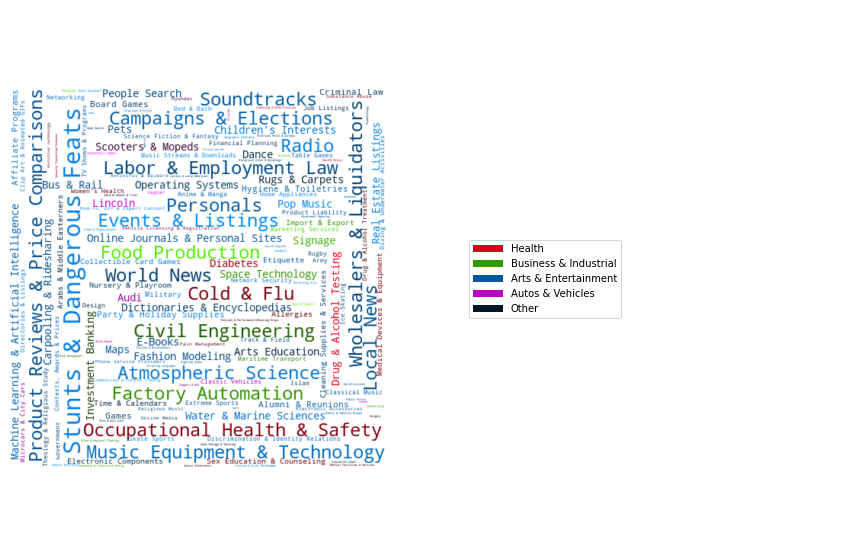

<Figure size 720x720 with 0 Axes>

In [47]:
# Nice colors from coolors.co
b=["#da0019","#339900","#005799","#bb00be","#011627"]

# Take all the categories name used for prediction and find their parent names
Parents = [str(categories_df[categories_df['id']==i]['parent'].values)[2:-2] for i in best_id['id0']]
words = [str(categories_df[categories_df['id']==i]['name'].values)[2:-2] for i in best_id['id0']]

# Count the frequency of the parent names and sort them 
s = CountFrequency(Parents)
s = {k: v for k, v in sorted(s.items(), key=lambda item: item[1],reverse=True)}

# Split the word in our color paletter according to the number of their parent occurancy
[words,color] = CountFreqColor(b, Parents,s,words)

# create the wordcloud
wc = WordCloud(relative_scaling=0.8 ,background_color="white",width=500, height=500).generate_from_frequencies(words)

# Add a default color for words
default_color = 'grey'

# Create a color function with multiple tones with our color dictionary using wordcloud function
grouped_color_func = GroupedColorFunc(color, default_color)

# Recolor our wordcloud
wc.recolor(color_func=grouped_color_func)

# Create a legend with the parent label
labels=list(s.keys())
legend_elements = []
# For each element add the correct color patch and parent name
for i in range(4):
    legend_elements.append(Patch(facecolor=b[i],label=labels[i]))
# for the last element add the final color patch and 'Other' as parent name
legend_elements.append(Patch(facecolor=b[4],label='Other'))

# Display the images in subplot
fig, (ax1, ax2) = plt.subplots(1,2)
#display legend
ax2.legend(handles=legend_elements, loc='center left', prop={'size': 10})
ax2.axis('off')

# Display the wordcloud image:
img_size = 30
plt.figure(figsize=(10, 10))#(img_size,img_size*16/9))
ax1.imshow(wc, interpolation='bilinear')
ax1.axis("off")

# Show plot
plt.show()

# 3. Final prediction and category visualization

## 3.1 Final prediction

Finally here is our best result, using only the best category overall.

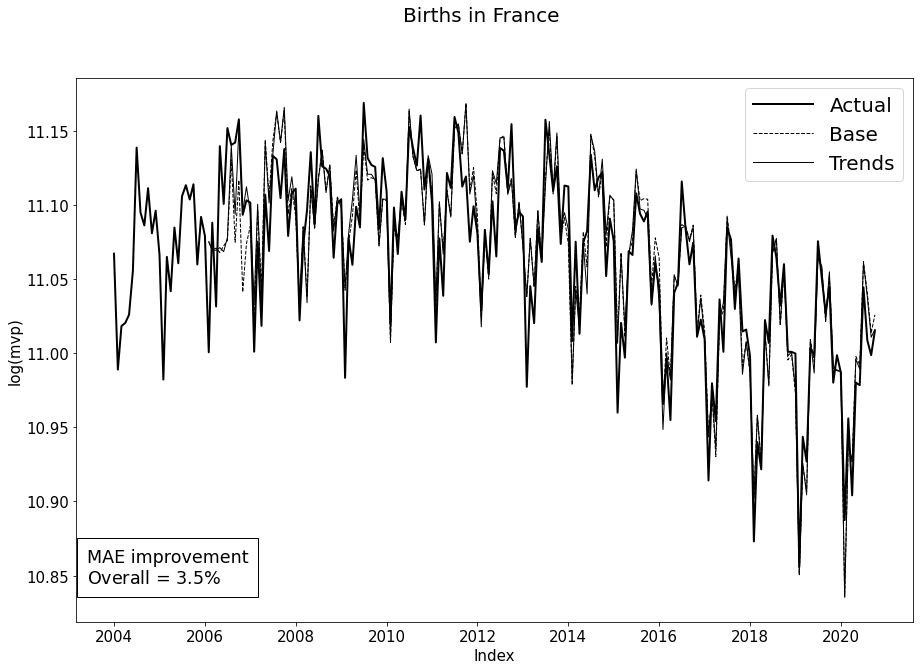

In [48]:
number_of_best_cat = 1
k=24

# find best feature overall
best_id = best_feature_improvement(k)
Best_categories = best_id

# Transforming the id into a date array for correct prediction
best_id = make_date_best(best_id)

# updating the months shift variable for later use
months_shift = k


# Reset dataframes
temp_df=pd.DataFrame(GTD_df, dtype='float')
df = birth_df.copy()

# Predict with these categories
# Create empty prediction
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
# for each date
for i in range(months_shift+1,len(birth_df)):
    # find current month
    j=birth_df.index[i]
    # find category corresponding to current month
    ids = best_id.loc[j,:]
    # Predict current value with current category
    pred = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    # Save prediction
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

# Save predictions
df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

# Compute maes and improvement
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base

showPlot(df, improvement_overall)